In [1]:
import pandas as pd
dataPath = r"C:\Users\HF\Desktop\Fall 2023\deep learning\menotme.csv"#use your own path
data = pd.read_csv(dataPath)

In [2]:
data = data.sample(frac = 1)
data["Label"] = data["Label"].astype('category')
data["Label"] = data["Label"].cat.codes

In [3]:
import cv2
import numpy as np
resized=[]

for i in data["Path"]:
    image = cv2.imread(i)
    # image = cv2.COLOR_BGR2RGB(image)
    resize=cv2.resize(image,(224,224))
    r = np.array(resize)
    resized.append(r)

In [4]:
resized=np.array(resized)

In [5]:
resized.shape

(153, 224, 224, 3)

In [6]:
y=data['Label']


In [7]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_one_hot_encoded = label_binarizer.fit_transform(y)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(resized, y_one_hot_encoded, test_size=0.2)

In [9]:
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.

In [13]:
x_train.shape

(122, 224, 224, 3)

In [17]:
import keras
from keras import layers


input_img = keras.Input(shape=(224, 224, 3)) 

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
latent_vector = layers.Flatten()(encoded) 


x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 8)         1160  

In [18]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                shuffle=True,
                validation_split=0.2)

Epoch 1/100
4/4 [==============================] - 11s 2s/step - loss: 0.6906 - val_loss: 0.6849
Epoch 2/100
4/4 [==============================] - 7s 2s/step - loss: 0.6836 - val_loss: 0.6775
Epoch 3/100
4/4 [==============================] - 7s 2s/step - loss: 0.6761 - val_loss: 0.6665
Epoch 4/100
4/4 [==============================] - 7s 2s/step - loss: 0.6655 - val_loss: 0.6512
Epoch 5/100
4/4 [==============================] - 7s 2s/step - loss: 0.6490 - val_loss: 0.6428
Epoch 6/100
4/4 [==============================] - 7s 2s/step - loss: 0.6379 - val_loss: 0.6290
Epoch 7/100
4/4 [==============================] - 7s 2s/step - loss: 0.6237 - val_loss: 0.6060
Epoch 8/100
4/4 [==============================] - 7s 2s/step - loss: 0.6198 - val_loss: 0.6152
Epoch 9/100
4/4 [==============================] - 8s 2s/step - loss: 0.6128 - val_loss: 0.6005
Epoch 10/100
4/4 [==============================] - 7s 2s/step - loss: 0.6039 - val_loss: 0.5959
Epoch 11/100
4/4 [====================

In [19]:
encoder = keras.Model(input_img, latent_vector)

In [20]:
encoded_imgs = encoder.predict(x_test)

1/1 [==============================] - 0s 366ms/step


In [21]:
encoded_imgs.shape

(31, 6272)

In [22]:
encoded_imgs2=encoder.predict(x_train)

4/4 [==============================] - 1s 181ms/step


In [23]:
import pickle
with open('latent.pkl', 'wb') as file:
    pickle.dump((encoded_imgs2), file)

In [41]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(encoded_imgs,encoded_imgs2)

print("Pairwise Cosine Similarities:",similarities)

# fun = lambda similarities : similarities if similarities>0.6 else 0
p=np.argmax(similarities,axis=1)
p

Pairwise Cosine Similarities: [[0.6403573  0.7970532  0.7405831  ... 0.7890124  0.81240165 0.7485531 ]
 [0.6874994  0.8227562  0.791679   ... 0.82412    0.87904274 0.7898649 ]
 [0.7193781  0.839874   0.8042129  ... 0.8389547  0.8650371  0.8299928 ]
 ...
 [0.7357154  0.8152269  0.8483534  ... 0.8711567  0.8639998  0.8422876 ]
 [0.71366274 0.894559   0.83131635 ... 0.9332339  0.87940073 0.8423052 ]
 [0.6078025  0.77456653 0.7594742  ... 0.8099752  0.8762835  0.70931506]]


array([ 46,  57,   9,  36, 107, 118,  12, 118, 101,  57, 108,  95, 108,
        46, 118,  56, 108,  73, 108, 118,  65,  18, 114, 117,  75,  82,
       104,  46,  95,  54, 118], dtype=int64)

In [25]:
path=data['Path'].to_list()

In [35]:
pred=[]
for i in p:
    pred.append(path[i])
pred[8]

'C:\\Users\\HF\\Desktop\\Fall 2023\\deep learning\\images of not me\\21_0_4_20161223214759249.jpg.chip.jpg'

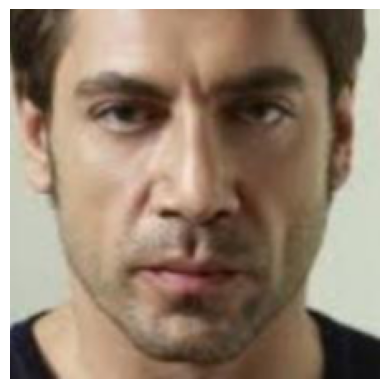

In [36]:
import matplotlib.pyplot as plt
plt.imshow(x_test[8][:,:,::-1])  
plt.axis('off')  
plt.show()
